# WD data -- Source matrices

Here we aggregate that cells from the 8 different batches and check them for cross-lane contamination, as well as describe the overall quality profile.

## Constructing Analysis Matrix

In [2]:
# Load
csv_arr <- Sys.glob("source/WD_DP*.coutt.csv")
plate_n <- as.integer(sub(".*_P([0-9]+)_([0-9]+).*", "\\1", csv_arr))
batch_n <- as.integer(sub(".*_P([0-9]+)_([0-9]+).*", "\\2", csv_arr))

message(batch_n)

matrices <- list()

res <- lapply(batch_n, FUN=function(i){
    batch <- i   
    plate <- plate_n[[i]]
    
    mat <<- read.table(csv_arr[[i]], header=T, row.names=1)
    # prepend headers with plate and batch
    # X1, X2 → P1_B1_X1
    tmp_names <- colnames(mat)
    tmp_names <- sub("(.*)", sprintf("P%d_B%d_\\1", plate, batch), tmp_names)
    colnames(mat) <- tmp_names
    matrices[[i]] <<- mat
    
    message("Plate", plate_n[[i]]," Batch", i, " - ", list(dim(matrices[[i]])))
})

12345678
Plate1 Batch1 - c(17460, 192)
Plate1 Batch2 - c(17657, 192)
Plate1 Batch3 - c(17418, 192)
Plate1 Batch4 - c(18182, 192)
Plate2 Batch5 - c(19232, 192)
Plate2 Batch6 - c(20596, 192)
Plate2 Batch7 - c(20752, 192)
Plate2 Batch8 - c(17905, 192)


Number of features are not equal - need to do cross join and then filter. 

For now it will be of interest to see how expressive each cell is, even with the contributions from genes that will not make it into the final analysis.

## Contamination check

### Pre-Merge

In [3]:
libsizes <- c()

res <- lapply(batch_n, FUN=function(i)
{
    pbkey <- paste(plate_n[[i]], batch_n[[i]], sep="_")
    matt <- matrices[[i]]
    libsizes <<- c(libsizes, colSums(matt))
})

libsizes <- cbind(libsizes, log(libsizes), log10(libsizes))
colnames(libsizes) <- c("libsizes", "ln", "log10")

rbind(head(libsizes,3),tail(libsizes,3))

,libsizes,ln,log10
P1_B1_X1,2280.8798,7.732317,3.358102
P1_B1_X2,1743.2260,7.463493,3.241354
P1_B1_X3,759.3018,6.632399,2.880414
P2_B8_X190,211.0333,5.352016,2.324351
P2_B8_X191,2494.6306,7.821896,3.397006
P2_B8_X192,700.2627,6.551455,2.845261


Blue [line] = plates
Red  [dots] = batches
No. cells with lib sizes > 20000 : 16


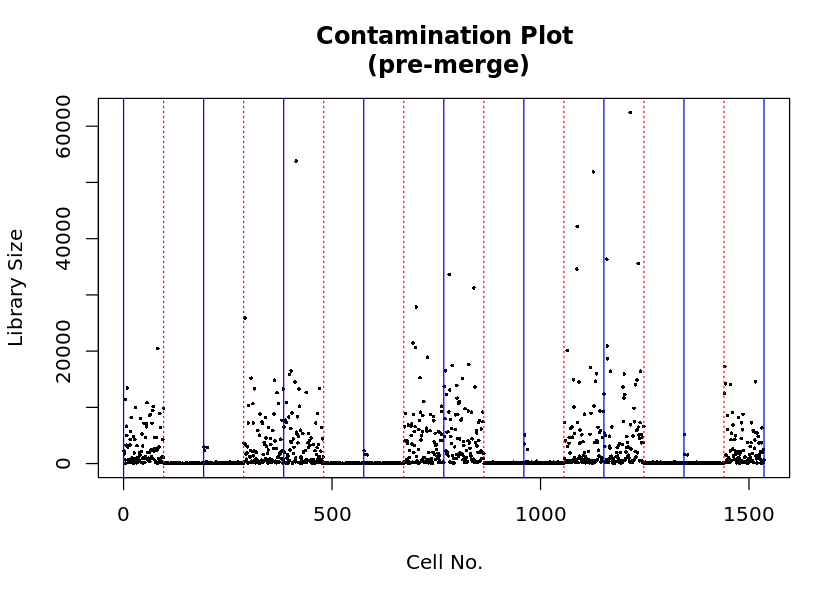

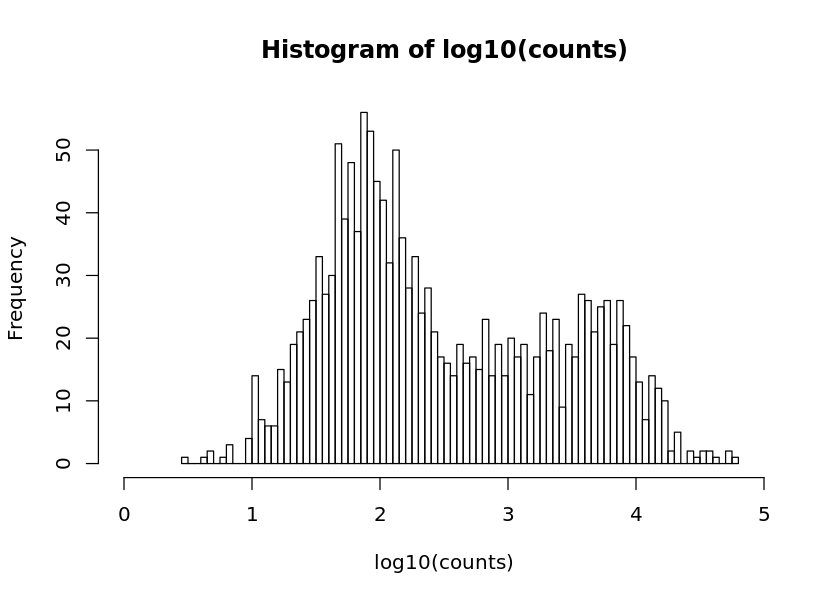

In [4]:
options(repr.plot.height = 5)

#plot(libsizes[,c("log10")])  # -- log/ln not really informative
     
contaminationPlot <- function(counts, title = "", filtered=F){
    plot(counts, pch = 16, cex = .4, ylab = "Library Size", xlab="Cell No.", 
         main = paste("Contamination Plot\n", title)
    )
    if (!(filtered)){
        abline(v=seq(96, 8 * 192, 192), col='red', lty=3)
        abline(v=seq( 0, 8 * 192, 192), col='blue')
    }
    else {
        abline(v=seq( 0, 8 * 96, 96), col='blue')
    }
    
    message("Blue [line] = plates")
    message("Red  [dots] = batches")
    message("No. cells with lib sizes > 20000 : ", sum(counts > 20000))

    hist(log10(counts), breaks = 100, xlim = c(0,5))
}

p_1 <- contaminationPlot(libsizes[,c("libsizes")], title = "(pre-merge)")

We see very little cross contamination between batches on the same plate. We also see only 16 cells with more than 20,000 counts with most of our cells within the range of 100 - 10,000, which is expected.

### Post-merge

Let us now repeat these metrics but with each of the 8 batches sharing the same number of features. This will show whether we lose any highly expressive genes during the merge process (this is can be a good and bad thing, depending on how relavent that gene is to our analysis).

In [5]:
#met <- Reduce(function(x,y) merge(x,y, 1, all = T, by = 'row.names'),matrices);

# Just keep it simple
commonInTwo <- function(m1, m2, names=F){
    if (names){
        r1 <- m1
        r2 <- m2
    }
    else {
        r1 <- rownames(m1)
        r2 <- rownames(m2)        
    }
    common_names <- r1[r1 %in% r2]
    return(common_names)
}
m1_m2 <- commonInTwo(matrices[[1]], matrices[[2]])
m3_m4 <- commonInTwo(matrices[[3]], matrices[[4]])
m5_m6 <- commonInTwo(matrices[[5]], matrices[[6]])
m7_m8 <- commonInTwo(matrices[[7]], matrices[[8]])

m12_m34 <- commonInTwo(m1_m2, m3_m4, names=T)
m56_m78 <- commonInTwo(m5_m6, m7_m8, names=T)

m1234_m5678 <- commonInTwo(m12_m34, m56_m78, names=T)

In [8]:
# - Frivoulous, leave for now.
#library(venneuler)
#venn <- venneuler(c(
#    "B1"=length(names(matrices[[1]])),
#    "B2"=length(names(matrices[[2]])),
#    "B3"=length(names(matrices[[3]])),
#    "B4"=length(names(matrices[[4]])),
#    "B5"=length(names(matrices[[5]])),
#    "B6"=length(names(matrices[[6]])),
#    "B7"=length(names(matrices[[7]])),
#    "B8"=length(names(matrices[[8]])),
#    
#    "B1&B2"=length(m1_m2),
#    "B3&B4"=length(m3_m4),
#    "B5&B6"=length(m5_m6),
#    "B7&B8"=length(m7_m8),
#    
#    "B1&B2&B3&B4"=length(m12_m34),
#    "B5&B6&B7&B8"=length(m56_m78),
#    "B1&B2&B3&B4&B5&B6&B7&B8"=length(m1234_m5678)
#    ))
#
#plot(venn)
                    

In [6]:
tab <- t(cbind(rbind(sapply(matrices, dim), batch_n), c(length(m1234_m5678), NA, "Merged")))
colnames(tab) <- c("Genes", "Cells", "Batch")
#tab[,c(1,3)]
rownames(tab) <- tab[,c("Batch")]
tab[,c(1,2)]

summary(as.integer(tab[,1])[1:8])

,Genes,Cells
1,17460,192
2,17657,192
3,17418,192
4,18182,192
5,19232,192
6,20596,192
7,20752,192
8,17905,192
Merged,11257,NA


   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  17418   17608   18044   18650   19573   20752 

From an average feature size of 18,650 we are now down to 11,257 common features between batches -- a very acceptable level of loss.

In [7]:
common_select <- lapply(matrices, FUN=function(mat){
    return(mat[rownames(mat) %in% m1234_m5678,])
})

In [8]:
# Simply horizontal cat
super_matrix <- do.call(cbind, common_select)
dim(super_matrix)

[1] 11257  1536

Blue [line] = plates
Red  [dots] = batches
No. cells with lib sizes > 20000 : 13


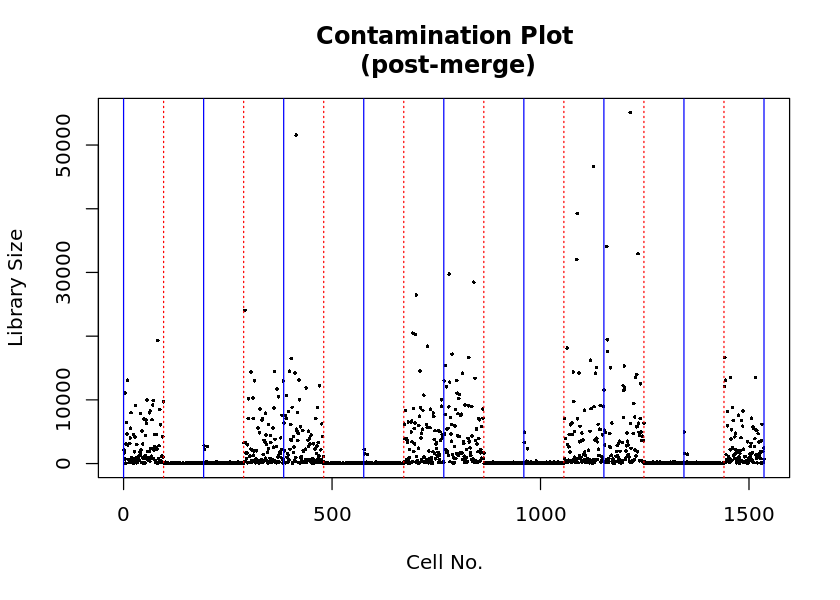

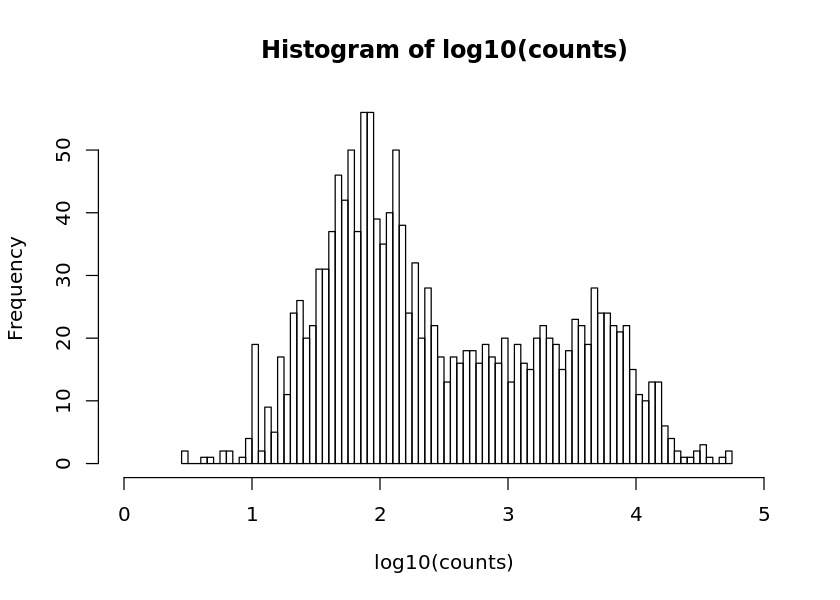

In [9]:
options(repr.plot.height = 5)
p_2 <- contaminationPlot(colSums(super_matrix), title="(post-merge)")

As we can see, there is no real change from the pre-merge metrics: instead of 16 cells over 20,000 we have 13 instead; the average library size still lies between 100 - 10,000 counts.

## Retaining wanted barcodes

We still have the 'cells' from the barcodes that were non-existent for that particular batch. Ideally we should have only cells selected from:

    Batch1, Batch3, Batch5, Batch7 →  barcodes001-96  
    Batch2, Batch4, Batch5, Batch6 →  barcodes097-192

In [13]:
nam <- colnames(super_matrix)
odd_barcodes <- nam[grepl("P\\d+_B\\d*[13579]_X([1-9]|[1-8][0-9]|9[0-6])$", nam)]
eve_barcodes <- nam[grepl("P\\d+_B\\d*[24680]_X(9[7-9]|[1-9][0-9]{2})$", nam)]

message("001 - 096 : ", length(odd_barcodes))
message("097 - 192 : ", length(eve_barcodes))
message("Overlap in barcodes :", sum(odd_barcodes %in% eve_barcodes))

c(head(odd_barcodes), tail(odd_barcodes))
c(head(eve_barcodes), tail(eve_barcodes))

001 - 096 : 384
097 - 192 : 384
Overlap in barcodes :0


[1] "P1_B1_X1"  "P1_B1_X2"  "P1_B1_X3"  "P1_B1_X4"  "P1_B1_X5"  "P1_B1_X6" 
 [7] "P2_B7_X91" "P2_B7_X92" "P2_B7_X93" "P2_B7_X94" "P2_B7_X95" "P2_B7_X96"

[1] "P1_B2_X97"  "P1_B2_X98"  "P1_B2_X99"  "P1_B2_X100" "P1_B2_X101"
 [6] "P1_B2_X102" "P2_B8_X187" "P2_B8_X188" "P2_B8_X189" "P2_B8_X190"
[11] "P2_B8_X191" "P2_B8_X192"

In [14]:
library(gtools)
wanted_codes <- mixedsort(c(odd_barcodes, eve_barcodes))   # human sort
#wanted_codes

[1] 11257   768

[1] 11257   768

Blue [line] = plates
Red  [dots] = batches
No. cells with lib sizes > 20000 : 0
Blue [line] = plates
Red  [dots] = batches
No. cells with lib sizes > 20000 : 13


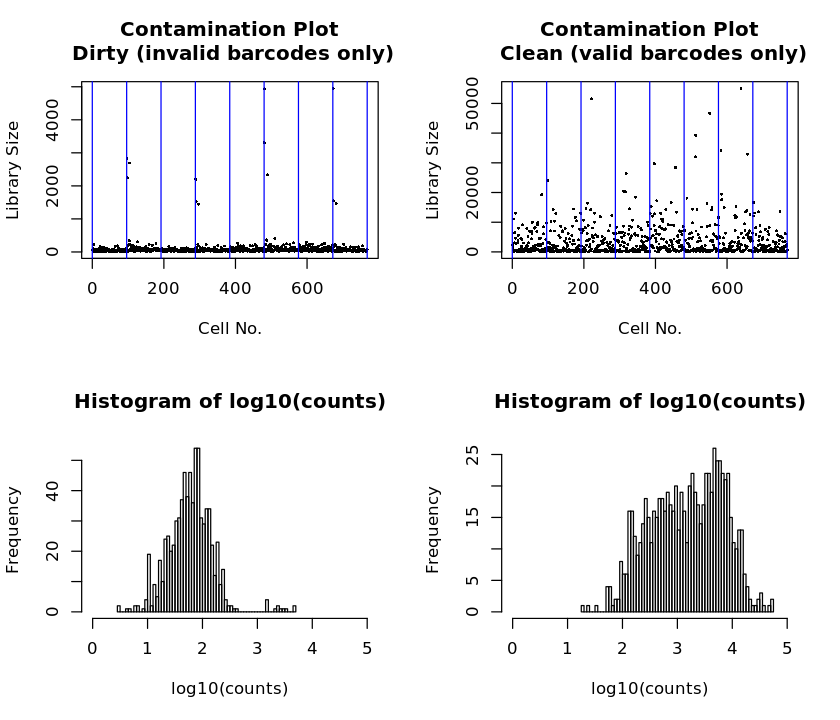

In [15]:
clean_matrix <- super_matrix[,wanted_codes]
dirty_matrix <- super_matrix[,!(colnames(super_matrix) %in% wanted_codes)]
#
dim(clean_matrix)
dim(dirty_matrix)

options(repr.plot.height = 6)
par(mfcol=c(2,2))
contaminationPlot(colSums(dirty_matrix), title="Dirty (invalid barcodes only)", filtered=T)
contaminationPlot(colSums(clean_matrix), title="Clean (valid barcodes only)", filtered=T)

With our false cells removed (10 - 100 counts), we notice a marked shift in the counts of the true cells towards 1,000-10,000 range.


## Feature Annotation

A quick look at our features reveals that they have rather uninformative  names:

In [18]:
head(rownames(clean_matrix),100)

[1] "ENSDARG00000000002" "ENSDARG00000000018" "ENSDARG00000000019"
  [4] "ENSDARG00000000068" "ENSDARG00000000069" "ENSDARG00000000086"
  [7] "ENSDARG00000000102" "ENSDARG00000000103" "ENSDARG00000000142"
 [10] "ENSDARG00000000161" "ENSDARG00000000183" "ENSDARG00000000189"
 [13] "ENSDARG00000000229" "ENSDARG00000000241" "ENSDARG00000000324"
 [16] "ENSDARG00000000370" "ENSDARG00000000384" "ENSDARG00000000394"
 [19] "ENSDARG00000000442" "ENSDARG00000000489" "ENSDARG00000000503"
 [22] "ENSDARG00000000529" "ENSDARG00000000542" "ENSDARG00000000551"
 [25] "ENSDARG00000000563" "ENSDARG00000000567" "ENSDARG00000000568"
 [28] "ENSDARG00000000606" "ENSDARG00000000631" "ENSDARG00000000666"
 [31] "ENSDARG00000000729" "ENSDARG00000000767" "ENSDARG00000000779"
 [34] "ENSDARG00000000796" "ENSDARG00000000837" "ENSDARG00000000853"
 [37] "ENSDARG00000000857" "ENSDARG00000000935" "ENSDARG00000000943"
 [40] "ENSDARG00000000966" "ENSDARG00000000972" "ENSDARG00000001009"
 [43] "ENSDARG00000001057" "ENSDARG00000001127" "ENSDARG00000001129"
 [46] "ENSDARG00000001162" "ENSDARG00000001210" "ENSDARG00000001220"
 [49] "ENSDARG00000001241" "ENSDARG00000001244" "ENSDARG00000001285"
 [52] "ENSDARG00000001447" "ENSDARG00000001463" "ENSDARG00000001549"
 [55] "ENSDARG00000001557" "ENSDARG00000001559" "ENSDARG00000001578"
 [58] "ENSDARG00000001621" "ENSDARG00000001634" "ENSDARG00000001676"
 [61] "ENSDARG00000001729" "ENSDARG00000001734" "ENSDARG00000001754"
 [64] "ENSDARG00000001760" "ENSDARG00000001769" "ENSDARG00000001776"
 [67] "ENSDARG00000001777" "ENSDARG00000001781" "ENSDARG00000001782"
 [70] "ENSDARG00000001785" "ENSDARG00000001788" "ENSDARG00000001803"
 [73] "ENSDARG00000001807" "ENSDARG00000001829" "ENSDARG00000001835"
 [76] "ENSDARG00000001857" "ENSDARG00000001870" "ENSDARG00000001873"
 [79] "ENSDARG00000001879" "ENSDARG00000001881" "ENSDARG00000001888"
 [82] "ENSDARG00000001889" "ENSDARG00000001890" "ENSDARG00000001891"
 [85] "ENSDARG00000001897" "ENSDARG00000001910" "ENSDARG00000001929"
 [88] "ENSDARG00000001930" "ENSDARG00000001940" "ENSDARG00000001950"
 [91] "ENSDARG00000001953" "ENSDARG00000001968" "ENSDARG00000001972"
 [94] "ENSDARG00000001994" "ENSDARG00000002002" "ENSDARG00000002006"
 [97] "ENSDARG00000002013" "ENSDARG00000002020" "ENSDARG00000002021"
[100] "ENSDARG00000002031"

ENSDARG suggests that they are GeneIDs and not Transcript IDs (ENSDART), so we must tread carefully and remove any duplicates that may occur.

Our reference genome was **Danio_rerio_Zv9_ens74_extended3_genes_ERCC92_GFP.fa**, i.e. ensembl release 74.

Let us look through the BioMart archives to find the annotations from that release:

In [19]:
suppressPackageStartupMessages(require(biomaRt))
listEnsemblArchives()

name,date,url,version,current_release
Ensembl GRCh37,Feb 2014,http://grch37.ensembl.org,GRCh37,
Ensembl 92,Apr 2018,http://apr2018.archive.ensembl.org,92,*
Ensembl 91,Dec 2017,http://dec2017.archive.ensembl.org,91,
Ensembl 90,Aug 2017,http://aug2017.archive.ensembl.org,90,
Ensembl 89,May 2017,http://may2017.archive.ensembl.org,89,
Ensembl 88,Mar 2017,http://mar2017.archive.ensembl.org,88,
Ensembl 87,Dec 2016,http://dec2016.archive.ensembl.org,87,
Ensembl 86,Oct 2016,http://oct2016.archive.ensembl.org,86,
Ensembl 85,Jul 2016,http://jul2016.archive.ensembl.org,85,
Ensembl 84,Mar 2016,http://mar2016.archive.ensembl.org,84,


Release 74: http://dec2013.archive.ensembl.org	

Let us this version to rename our features, and see how many duplicate genes/transcripts we find, and whether this is better or worse than using the latest ensembl release.

### Ensembl version duplicate gene test

In [26]:
namers <- rownames(clean_matrix)

mart <- useMart(biomart = "ENSEMBL_MART_ENSEMBL" , dataset = "drerio_gene_ensembl", host = 'http://dec2013.archive.ensembl.org')
filt <- "ensembl_gene_id"
k <- getBM(
    filters = filt,
    attributes = c(filt, "external_gene_id"),
    values = namers,
    mart = mart
)

map <- unique(k[,c(filt, "external_gene_id")])
message(dim(map[duplicated(map$external_gene_id),])[1], " duplicates")

140 duplicates


In [27]:
namers <- rownames(clean_matrix)

mart <- useMart(biomart = "ENSEMBL_MART_ENSEMBL" , dataset = "drerio_gene_ensembl")
filt <- "ensembl_gene_id"
k <- getBM(
    filters = filt,
    attributes = c(filt, "external_gene_name"),
    values = namers,
    mart = mart
)

map <- unique(k[,c(filt, "external_gene_name")])
message(dim(map[duplicated(map$external_gene_name),])[1], " duplicates")

20 duplicates


So we would lose less if we use a newer reference to annotate our genes.

### Perform the Annotation

In [30]:
replaceRowNames <- function(namers, dataset = "drerio_gene_ensembl"){
    mart <- useMart(biomart = "ENSEMBL_MART_ENSEMBL" , dataset = dataset)
    #listDatasets(mart)
    #listAttributes(mart)
    filt <- NULL

    if (dataset == "drerio_gene_ensembl"){
        filt <- "ensembl_gene_id"
    } else if (dataset == "mmusculus_gene_ensembl") {
        filt <- "mgi_symbol"
    } else {
        message("ERROR: Dataset ", dataset, "is NOT configured")
    }

    k <- getBM(
        filters = filt,
        attributes = c(filt, "external_gene_name"),
        values = namers,
        mart = mart
    )
    
    ens2ext_map <- unique(k[,c(filt, "external_gene_name")])
    mer <- (merge(namers, ens2ext_map, all = T, by.x = 1, by.y = filt))

    num_to_replace <- dim(mer[is.na(mer$external_gene_name),])[1]
    message(num_to_replace, " to be replaced")

    bad_names <- sapply(mer[is.na(mer$external_gene_name),]$x, toString)
    mer[is.na(mer$external_gene_name),]$external_gene_name <- bad_names

    num_were_replaced <- dim(mer[mer$x == mer$external_gene_name,])[1]
    if (num_to_replace != num_were_replaced){
        message("Not all replaced...!")
    }
    
    return(mer$external_gene_name)
}

In [36]:
current_names <- rownames(clean_matrix)
updated_names <- replaceRowNames(current_names)

message(
    "Current Names: ", length(current_names), 
    ", Update Names: ", length(updated_names), 
    " of which ", length(updated_names) - length(unique(updated_names)), " are duplicates")

1852 to be replaced
Current Names: 11257, Update Names: 11257 of which 20 are duplicates


1852 genes had no 'external gene name' so we will keep their original ensemble for these.
The duplicates we will have to handle seperately.

## Duplicates Genes

What do we do with duplicates? If we remove the wrong one, we might lose a significant gene of interest.

Maybe we can reduce some of these duplicates:
  * If they are of poor quality
  * If they share the same expression profile (e.g. same relative DE in the same cells) we can eliminate the one with the less transcripts.
  * Choosing the transcript with the greatest DE (e.g. higher maximum expression, across more cells)
  
#### Methods


In [554]:
expressedInWhichCells <- function(row){
    #names(row[row > 0])
    nz_vals <- row[row > 0]
    mm <- max(nz_vals)
    mi <- nz_vals[nz_vals == mm]
    return(
        c(
            NCells = length(nz_vals), 
            MaxVal = mm, 
            MaxValCells = paste(names(mi), collapse=", ")
        )
    )
}


reportDuplicates <- function(current_new, mat){
    df <- current_new

    dupes <- df[df$new %in% df[duplicated(df$new),]$new,]
    dupes <- cbind(dupes, rowSums(mat[dupes$current,]))

    colnames(dupes) <- c("current","new","rowSums")
    #dupes[order(dupes$new),]

    res <- apply(mat[dupes$current,], 1, expressedInWhichCells)
    dupes <- cbind(dupes, t(res))
    return(dupes[order(dupes$new),])
}


chooseMostInformativeTranscript <- function(test_gene){
    toconsider <- dupes[dupes$new == test_gene,]

    # Determine commonCell
    cnames <- toconsider$MaxValCells
    unique_names <- as.character((unlist(sapply(as.character(cnames),FUN=function(x){strsplit(x,"\\s*,\\s*")}))))
    freq <- table(unique_names)
    common_cell <- names(freq[freq == length(cnames)])

    has_commoncell <- length(common_cell) > 0

    # Generate a score based on rowSums, and NumCells
    #toconsider
    lowestRowSum <- min(toconsider$rowSums)
    lowestNCells <- min(toconsider$NCells)
    lowestMaxValue <- min(toconsider$MaxVal)
    x <- toconsider[1,]

    scoreForTranscript <- function(row){
        rowS <- as.numeric(row[3])
        ncel <- as.numeric(row[4])
        maxv <- as.numeric(row[5])
        maxc <- length(unlist(strsplit(row[6],"\\s*,\\s*")))

        score <- (rowS / lowestRowSum) + (ncel / lowestNCells) + (maxv/lowestMaxValue) + log10(maxc)
        return(score)
    }

    scores <- apply(toconsider, 1, scoreForTranscript)
    tmp <- cbind(toconsider, scores) #[scores == max(scores)]
    
    #accept <- tmp[tmp$scores == max(tmp$scores),]$current
    #reject <- tmp[tmp$scores != max(tmp$scores),]$current
    tmp$accept <- F
    tmp[tmp$scores == max(tmp$scores),]$accept <- T
    #tmp[tmp$scores != max(tmp$scores),]$accept <- F

    return(tmp)
    #message("Accept:", accept, ", Reject:", reject) 
}

### Pruning duplicates

Here we can see the duplicate features, their total transcripts (rowSums), the number of cells they are expressed in, the maximum expression value for that transcript, and which cell(s) expressed the maximum.

Adjacent rows can tell us if any duplicates share the same cells expressing maximum values, which we can then eliminate.

We can also create a scoring system that takes into account these factors and chooses the most informative transcript, the results of which are shown below:

In [556]:
df <- data.frame(current=current_names, new=updated_names)
dupes <- reportDuplicates(df, clean_matrix)
as.numeric.factor <- function(x) {as.numeric(levels(x))[x]}
dupes[,c("NCells","MaxVal")] <- sapply(dupes[,c("NCells","MaxVal")], as.numeric.factor)
#dupes
genelist <- unique(dupes$new)
#test_gene <- genelist[2]
#chooseMostInformativeTranscript(test_gene)
dupes <- do.call(rbind, lapply(genelist, chooseMostInformativeTranscript))
dupes

,current,new,rowSums,NCells,MaxVal,MaxValCells,scores,accept
7153,ENSDARG00000061736,ank3b,358.13535,183,9.009902,"P1_B2_X99, P1_B2_X180",4.530178,TRUE
9210,ENSDARG00000077582,ank3b,246.08795,123,7.005988,P1_B1_X4,3.000000,FALSE
188,ENSDARG00000002790,ap2m1b,515.23692,228,13.020674,P2_B5_X13,8.335591,TRUE
3682,ENSDARG00000033899,ap2m1b,119.02968,89,9.009902,P1_B4_X124,3.000000,FALSE
490,ENSDARG00000005122,atp2a2a,133.03579,88,6.004399,P2_B7_X63,9.954502,TRUE
3263,ENSDARG00000029439,atp2a2a,30.00513,25,3.001099,P1_B1_X87,3.000000,FALSE
5272,ENSDARG00000044902,atp2b2,764.45587,281,15.027533,P2_B8_X97,7.626046,TRUE
7532,ENSDARG00000063433,atp2b2,237.06681,148,6.004399,"P2_B5_X14, P2_B8_X97",3.301030,FALSE
496,ENSDARG00000005159,cyth1a,190.05496,121,7.005988,P2_B5_X72,5.823024,TRUE
9002,ENSDARG00000076742,cyth1a,84.02198,56,5.003054,P2_B5_X45,3.000000,FALSE


#### Manual Pruning
Prior to scoring, I attempted to curate this list manually myself under the following criterion:

 * A : Features that share a max value cell but one transcript has stronger DE
 * B : Features that share a max value cell, but one transcript is not significantly better than another
 * C : Features that don't share a max value cell, but one transcript is of better quality
 * D : Features that don't share a max value cell, transcripts are of similar quality, but one has more DE
 * E : Features that don't share a max value cell, are of low quality, and either can be picked


 | Gene | Chosen | Rejected | Category |  
 |------|--------|----------|----------|
 | ank3b | ENSDARG00000061736 | ENSDARG00000077582 | D |
 | ap2m1b | ENSDARG00000002790 | ENSDARG00000033899 | C |
 | atp2a2a | ENSDARG00000005122 | ENSDARG00000029439 | C |
 | atp2b2 | ENSDARG00000044902 | ENSDARG00000063433 | A |
 | cyth1a | ENSDARG00000005159 | ENSDARG00000076742 | C |
 | gtf2h4 | ENSDARG00000007136 | ENSDARG00000036071 | C |
 | h3f3b.1 | ENSDARG00000020504 | ENSDARG00000068434, ENSDARG00000068436 | A |
 | hnrnpa0l | ENSDARG00000036161 | ENSDARG00000076380 | C |
 | kat5b | ENSDARG00000004587 | ENSDARG00000045951 | D |
 | matr3l1.1 | ENSDARG00000001162 | ENSDARG00000000394 | D | 
 | pou2f2a | ENSDARG00000036816 | ENSDARG00000019658 | C |
 | rpl37 | ENSDARG00000034291 | ENSDARG00000076360 | A |
 | rsf1b.1  | ENSDARG00000093503 | ENSDARG00000068640 | D | 
 | scg5 | ENSDARG00000077045 | ENSDARG00000032126 | C |
 | si:ch73-266f23.1 | ENSDARG00000074298 | ENSDARG00000095135 | E |
 | si:dkey-20i20.8 | ENSDARG00000071714 | ENSDARG00000094343 | E |
 | sinhcafl | ENSDARG00000095007 | ENSDARG00000078118 | E |
 | soga3a | ENSDARG00000088571 | ENSDARG00000063311 | C |
 | tuba1c | ENSDARG00000055216 | ENSDARG00000045367 | C |
 


With the scoring system develop, we can verify that this good accordance between mine and the manual sets with the exception of *kat5b* which was a marginal difference at best:

  
#### Automatic Pruning


In [559]:
dupes[dupes$accept,]

,current,new,rowSums,NCells,MaxVal,MaxValCells,scores,accept
7153,ENSDARG00000061736,ank3b,358.13535,183,9.009902,"P1_B2_X99, P1_B2_X180",4.530178,TRUE
188,ENSDARG00000002790,ap2m1b,515.23692,228,13.020674,P2_B5_X13,8.335591,TRUE
490,ENSDARG00000005122,atp2a2a,133.03579,88,6.004399,P2_B7_X63,9.954502,TRUE
5272,ENSDARG00000044902,atp2b2,764.45587,281,15.027533,P2_B8_X97,7.626046,TRUE
496,ENSDARG00000005159,cyth1a,190.05496,121,7.005988,P2_B5_X72,5.823024,TRUE
738,ENSDARG00000007136,gtf2h4,124.02760,91,5.003054,"P1_B2_X108, P2_B6_X189",9.051332,TRUE
2459,ENSDARG00000020504,h3f3b.1,1185.26218,361,57.400325,P1_B3_X30,5.247119,TRUE
3986,ENSDARG00000036161,hnrnpa0l,1098.11193,343,34.141899,P1_B3_X30,41.064936,TRUE
5454,ENSDARG00000045951,kat5b,53.01062,41,4.001954,P2_B6_X128,3.523241,TRUE
46,ENSDARG00000001162,matr3l1.1,219.06510,128,6.004399,"P1_B1_X82, P2_B7_X63",3.563707,TRUE


We will therefore drop the following transcripts from our matrix:

In [596]:
drop_list <- c(as.character(dupes[!dupes$accept,]$current))
drop_list

pruned_matrix <- clean_matrix[!(rownames(clean_matrix) %in% drop_list),]
t(data.frame(clean = dim(clean_matrix), pruned = dim(pruned_matrix), row.names=c("features","cells")))

[1] "ENSDARG00000077582" "ENSDARG00000033899" "ENSDARG00000029439"
 [4] "ENSDARG00000063433" "ENSDARG00000076742" "ENSDARG00000036071"
 [7] "ENSDARG00000068434" "ENSDARG00000068436" "ENSDARG00000076380"
[10] "ENSDARG00000004587" "ENSDARG00000000394" "ENSDARG00000019658"
[13] "ENSDARG00000076360" "ENSDARG00000068640" "ENSDARG00000032126"
[16] "ENSDARG00000095135" "ENSDARG00000094343" "ENSDARG00000078118"
[19] "ENSDARG00000063311" "ENSDARG00000045367"

,features,cells
clean,11257,768
pruned,11237,768


Now let's re-run the annotation step with our pruned matrix and see if we encounter any duplicated transcripts

## Feature Annotation Re-Run



In [597]:
current_names <- rownames(pruned_matrix)
updated_names <- replaceRowNames(current_names)

message(
    "Current Names: ", length(current_names), 
    ", Update Names: ", length(updated_names), 
    " of which ", length(updated_names) - length(unique(updated_names)), " are duplicates")

1852 to be replaced
Current Names: 11237, Update Names: 11237 of which 0 are duplicates


Good. Now we can updated the names non-problematically:

In [598]:
rownames(pruned_matrix) <- updated_names
head(pruned_matrix)

,P1_B1_X1,P1_B1_X2,P1_B1_X3,P1_B1_X4,P1_B1_X5,P1_B1_X6,P1_B1_X7,P1_B1_X8,P1_B1_X9,P1_B1_X10,⋯,P2_B8_X183,P2_B8_X184,P2_B8_X185,P2_B8_X186,P2_B8_X187,P2_B8_X188,P2_B8_X189,P2_B8_X190,P2_B8_X191,P2_B8_X192
ccdc80,0,0.000000,0,0.000000,0,0.000000,0.000000,0,0.000000,0.000000,⋯,0,0,0,0,0,0,0.000000,0,0.000000,0
nrf1,0,0.000000,0,0.000000,0,1.000122,1.000122,0,0.000000,0.000000,⋯,0,0,0,0,0,0,0.000000,0,0.000000,0
ube2h,0,0.000000,0,3.001099,0,1.000122,1.000122,0,1.000122,1.000122,⋯,0,0,0,0,0,0,0.000000,0,0.000000,0
slc9a3r1a,0,0.000000,0,0.000000,0,0.000000,0.000000,0,0.000000,0.000000,⋯,0,0,0,0,0,0,0.000000,0,0.000000,0
dap,0,0.000000,0,1.000122,0,0.000000,0.000000,0,1.000122,0.000000,⋯,0,0,0,0,0,0,1.000122,0,0.000000,0
itsn1,0,1.000122,0,0.000000,0,0.000000,0.000000,0,0.000000,0.000000,⋯,0,0,0,0,0,0,0.000000,0,1.000122,0


Fantastic. Save this matrix and use it for all downstream analyses.

In [599]:
saveRDS(pruned_matrix, "source/cleaned_matrix.rds")